In [1]:
import os
import pandas as pd
from tqdm import tqdm
from glob import glob
from dotenv import load_dotenv
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from experiment_4.dataset import AEDataset
from experiment_4.model import Detector
from utils.s3_download import list_all_objects, s3_client
from pathlib import Path
from PIL import Image
from multiprocessing import Pool


load_dotenv(override=True)

tqdm.pandas()

EXPERIMENT_FOLDER = "experiment_4"

device = "cuda:0"
dtype = torch.bfloat16

/home/teekh/workspace/git_personal/image-detection-model-experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BUCKET_NAME = os.getenv("BUCKET_NAME")
LOCAL_BUCKET_FOLDER = os.getenv("LOCAL_BUCKET_FOLDER")
SELECTED_FOLDER = os.getenv("SELECTED_FOLDER")
IMAGE_SIZE = eval(os.getenv("IMAGE_SIZE"))

#selected_date = '2023-11-27T16-02-52'
selected_date = '2023-10-25T17-14-11'

def list_files_to_download(s3_folder:str):
    s3_files = list_all_objects(s3_client, BUCKET_NAME, s3_folder)
    print(f"Number of files in {BUCKET_NAME}/{s3_folder}: {len(s3_files)}")
    s3_files = [k['Key'] for k in s3_files if not k['Key'].endswith('/')]
    return s3_files

prefix_ignore = [
    'VW5pZGVudGlmaWVkPE82a0RqPmJib3ggbm90IGNsZWFuZWQ8TzZrRGo-eWVsbG93IG5hcnJvdyB0cmlhbmdsZSB3aXJlIGhvbGRlcg==',
    'VW5pZGVudGlmaWVkPE82a0RqPmJib3ggbm90IGNsZWFuZWQ8TzZrRGo-Z3JleSBib3g=',
]
s3_files = list_files_to_download(f"{SELECTED_FOLDER}/{selected_date}")
s3_files = [f for f in s3_files if f.split('/')[2] not in prefix_ignore]
print(f"Number of files for training (includes jpg and json): {len(s3_files)}")

listing s3 objects: 2it [00:02,  1.05s/it]

Number of files in sg-implement/prod_selected/2023-10-25T17-14-11: 1152
Number of files for training (includes jpg and json): 1152


In [3]:
def download_and_resize(file:str, s3_client=s3_client):
    local_save_folder = Path(f"{EXPERIMENT_FOLDER}")
    local_img_path = local_save_folder / file
    if local_img_path.exists():
        return False
    local_img_path.parent.mkdir(parents=True, exist_ok=True)
    s3_client.download_file(BUCKET_NAME, file, str(local_img_path))
    if local_img_path.suffix == '.jpg':
        img = Image.open(local_img_path)
        img.save(local_img_path)
    return True

def download_images(s3_files:list[str]):
    with Pool(16) as p:
        r = list(tqdm(p.imap(download_and_resize, s3_files), total=len(s3_files)))
    num_downloaded = sum(r)
    print(f"Number of files downloaded: {num_downloaded}")
    return num_downloaded

num_downloaded = download_images(s3_files)

100%|██████████| 1152/1152 [00:00<00:00, 10563.93it/s]

Number of files downloaded: 0


In [4]:
import matplotlib.pyplot as plt
from base64 import urlsafe_b64decode
from random import sample
from PIL import Image
import json


load_dotenv(override=True)


def get_image_name(image_path, offset:int):
    return '/'.join(image_path.split('/')[offset:]).split('.')[0]

def images_split(images_df: pd.DataFrame, train_size: float = 0.90, val_size: float = 0.05, test_size: float = 0.05, random_state: int = 42):
    assert train_size + val_size + test_size == 1
    train_df = images_df.sample(frac=train_size, random_state=random_state)
    val_df = images_df.drop(train_df.index).sample(frac=val_size / (1 - train_size), random_state=random_state)
    test_df = images_df.drop(train_df.index).drop(val_df.index)
    return train_df, val_df, test_df

def get_bbox_from_json_path(json_path):
    with open(json_path) as json_file:
        json_data = json.load(json_file)
        return json_data['new_bounding_box']

labeled_df = pd.DataFrame({
    'json_path': glob(EXPERIMENT_FOLDER + "/prod_selected/**/*.json", recursive=True)
})
labeled_df['image_path'] = labeled_df.json_path.apply(lambda x: x.replace('.json', '.jpg'))
labeled_df['implement_class'] = labeled_df.json_path.apply(lambda x: x.split('/')[3])
labeled_df['implement_class'] = labeled_df['implement_class'].apply(lambda x: urlsafe_b64decode(x).decode("utf-8").replace('<O6kDj>', ';'))
labeled_df = labeled_df.merge(
    pd.json_normalize(labeled_df.json_path.apply(lambda x: get_bbox_from_json_path(x))),
    left_index=True,right_index=True
)
implements_to_exclude = [
    'Unidentified;bbox not cleaned;yellow narrow triangle wire holder',
    'Unidentified;bbox not cleaned;grey box',
]
labeled_df = labeled_df[~labeled_df.implement_class.isin(implements_to_exclude)]
labeled_df.value_counts('implement_class')
labeled_df

,json_path,image_path,implement_class,left,right,upper,bottom
0,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Flail Mower;Tierre;Lupo Revers 140,574,1403,270,756
1,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Flail Mower;Tierre;Lupo Revers 140,636,1335,368,756
2,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Flail Mower;Tierre;Lupo Revers 140,615,1336,365,756
3,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Flail Mower;Tierre;Lupo Revers 140,555,1460,225,756
4,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Flail Mower;Tierre;Lupo Revers 140,550,1470,222,756
...,...,...,...,...,...,...,...
1607,experiment_4/prod_selected/2023-10-25T17-14-11...,experiment_4/prod_selected/2023-10-25T17-14-11...,Disc;Domries;SN-2324,469,1446,165,1152
1608,experiment_4/prod_selected/2023-10-25T17-14-11...,experiment_4/prod_selected/2023-10-25T17-14-11...,Disc;Domries;SN-2324,470,1452,165,1152
1609,experiment_4/prod_selected/2023-10-25T17-14-11...,experiment_4/prod_selected/2023-10-25T17-14-11...,Disc;Domries;SN-2324,469,1453,180,1152
1610,experiment_4/prod_selected/2023-10-25T17-14-11...,experiment_4/prod_selected/2023-10-25T17-14-11...,Disc;Domries;SN-2324,473,1456,184,1152


In [5]:
def train_test_split(df: pd.DataFrame, train_size: float = 0.05, val_size:float = .05, test_size:float=.90, random_state: int = 42):
    # perform split by implement_class
    # cap df at 100 images per implement_class
    assert train_size + val_size + test_size == 1, "train_size + val_size + test_size must equal 1"
    train_splits = []
    val_splits = []
    test_splits = []
    for g, gdf in df.groupby('implement_class'):
        train_df = gdf.sample(frac=train_size, random_state=random_state)
        remaining_df = gdf.drop(train_df.index)
        val_df = remaining_df.sample(frac=val_size / (1 - train_size), random_state=random_state)
        test_df = remaining_df.drop(val_df.index)
        train_splits.append(train_df)
        val_splits.append(val_df)
        test_splits.append(test_df)
    train_df = pd.concat(train_splits).reset_index(drop=True)
    val_df = pd.concat(val_splits).reset_index(drop=True)
    test_df = pd.concat(test_splits).reset_index(drop=True)
    return train_df, val_df, test_df

train_df, val_df, test_df = train_test_split(labeled_df, random_state=42)
training_summary_df = pd.DataFrame({
    'train': train_df.implement_class.value_counts(),
    'val': val_df.implement_class.value_counts(),
    'test': test_df.implement_class.value_counts(),
}); training_summary_df

,train,val,test
implement_class,,,
Disc;Domries;SN-2324,8,7,135
Flail Mower;Agrimaster;Yoyo 1500,8,7,135
Flail Mower;Nobili;VK 115,8,7,135
Flail Mower;Tierre;Lupo Revers 140,8,7,135
Rotary Mower;Bush Hog;BH215,8,7,135
Seeder;Schmeiser;VD48PW,8,7,135
Seeder;Schmeiser;VD60PW,8,7,135
Seeder;Schmeiser;VD72PW,8,7,135
Box Scraper;Land Pride;BB1272,6,6,106


In [6]:
train_ds = AEDataset(train_df)
val_ds = AEDataset(val_df)
test_ds = AEDataset(test_df)

dl_config = {
    "batch_size": 8,
    "shuffle": True,
    "num_workers": 8,
    "drop_last": True,
}
test_dl_config = {
    "batch_size": 1,
    "shuffle": True,
    "num_workers": 1,
    "drop_last": False,
}
evaluation_dl_config = {
    "batch_size": 1,
    "shuffle": False, # preserve same order as dataframe
    "num_workers": 1,
    "drop_last": False,
}

train_dl = DataLoader(train_ds, **dl_config)
val_dl = DataLoader(val_ds, **dl_config)
test_dl = DataLoader(test_ds, **test_dl_config)
eval_dl = DataLoader(test_ds, **evaluation_dl_config)  # same as test_ds, for evaluation

In [7]:
def initialize_model():
    model = Detector(len(train_ds.implement_classes),dropout=.02).to(torch.bfloat16).to(device)
    model.load_state_dict(torch.load(f'{EXPERIMENT_FOLDER}/model.pth', map_location=device))
    return model
model = initialize_model()

In [8]:
def count_model_params(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    return trainable_params, total_params
count_model_params(model)

(2112426, 2112426)

In [9]:
model.load_state_dict(torch.load(f'{EXPERIMENT_FOLDER}/model.pth', map_location=device))

<All keys matched successfully>

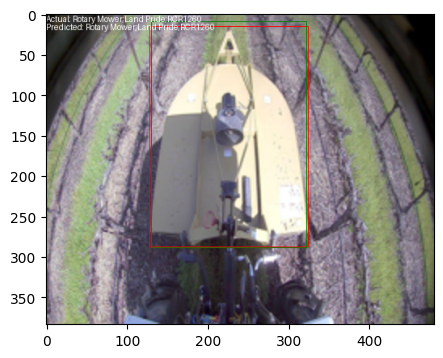

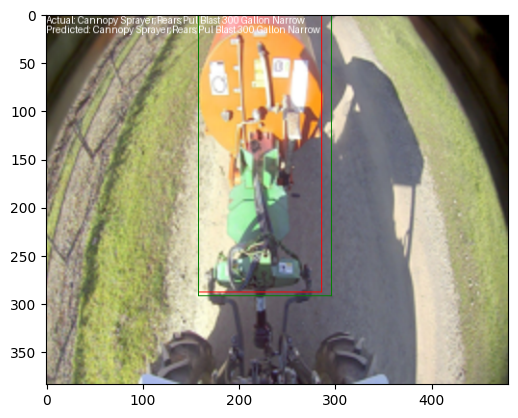

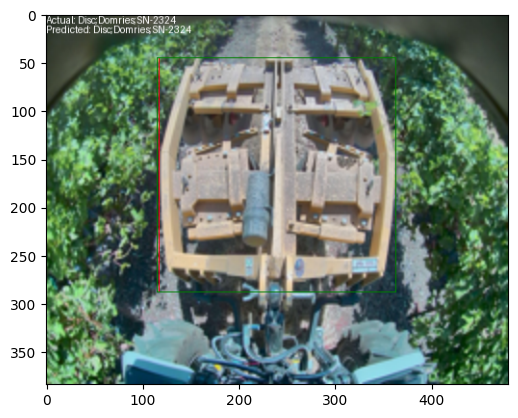

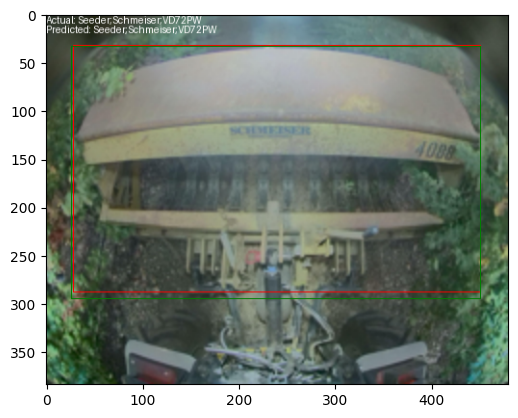

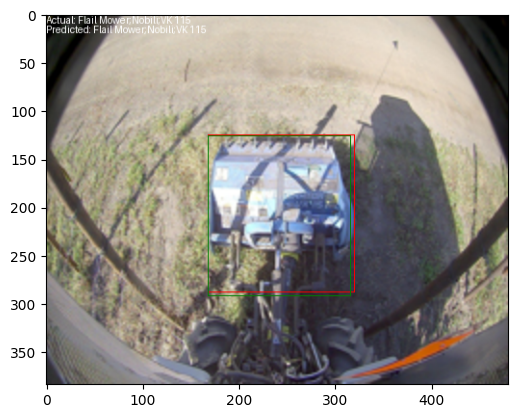

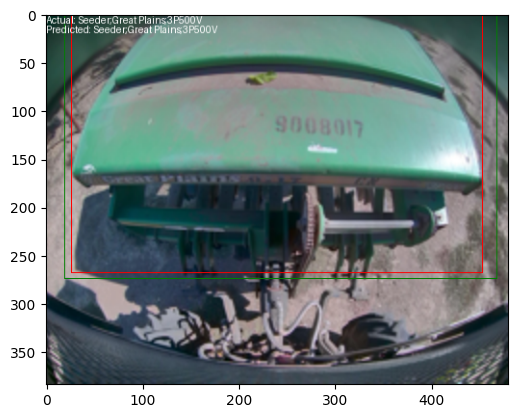

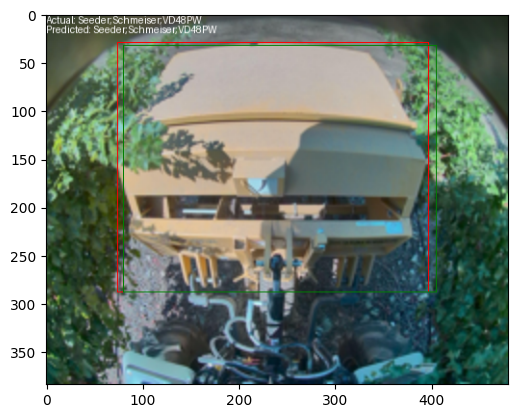

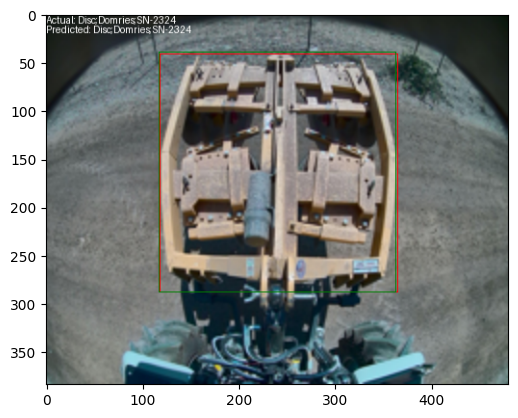

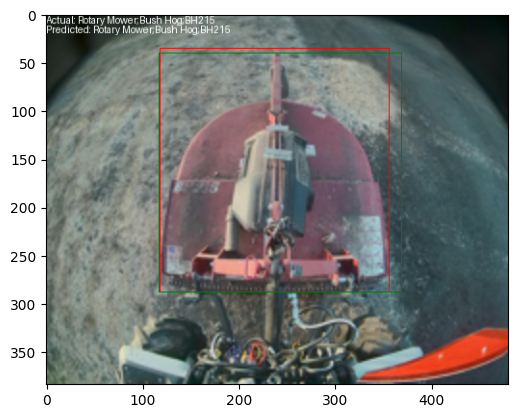

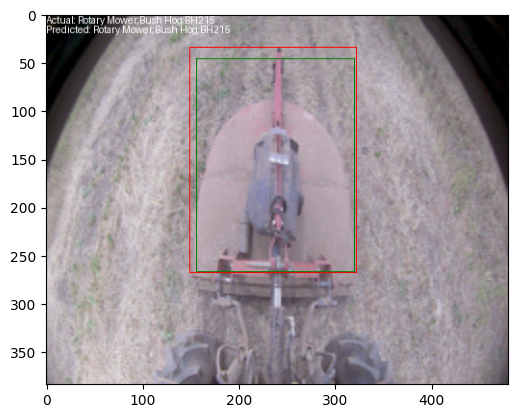

In [10]:
from PIL import ImageDraw


def format_bbox(bbox, size):
    # bbox is [left, right, upper, bottom]
    # return [left, upper, right, bottom] multiplied by image size
    # size is (width, height)
    return bbox[0] * size[0], bbox[2] * size[1], bbox[1] * size[0], bbox[3] * size[1]

def plot_test_image_predictions(model, test_dl, device='cuda', dtype=torch.bfloat16, max_images = 10):
    model.eval()
    num_plotted = 0
    with torch.no_grad():
        fig, ax = plt.subplots(1,1,figsize=(5,5))
        for data in test_dl:
            # data is a dict of [images, implement_class, left, right, upper, bottom]
            images = data['image'].to(device=device, dtype=dtype)
            implement_class = data['implement_class'].to(device=device, dtype=torch.long)
            bbox = data['bbox'].to(device=device, dtype=dtype)
            pred = model(images)
            pred_class = pred[:, :len(test_dl.dataset.implement_classes)]
            pred_bbox = pred[:, len(test_dl.dataset.implement_classes):]
            pred_class = pred_class.argmax(dim=1)
            pred_bbox = pred_bbox.to(torch.float).cpu().numpy()
            pred_class = pred_class.to(torch.float).cpu().numpy()
            bbox = bbox.to(torch.float).cpu().numpy()
            implement_class = implement_class.cpu().numpy()
            for i in range(len(images)):
                img = images[i].to(torch.float).cpu().numpy().transpose(1,2,0)
                img = (img * 255).astype('uint8')
                img = Image.fromarray(img)
                img = img.resize((IMAGE_SIZE[0]*2, IMAGE_SIZE[1]*2))
                img = img.convert('RGB')
                img = img.copy()
                draw = ImageDraw.Draw(img)
                draw.rectangle(format_bbox(bbox[i],img.size), outline='red')
                draw.rectangle(format_bbox(pred_bbox[i],img.size), outline='green')
                draw.text((0,0), f"Actual: {test_dl.dataset.implement_classes[int(implement_class[i])]}")
                draw.text((0,10), f"Predicted: {test_dl.dataset.implement_classes[int(pred_class[i])]}")
                plt.imshow(img)
                plt.show()
                num_plotted += 1
                if num_plotted >= max_images:
                    return

plot_test_image_predictions(model, test_dl, device, dtype)

In [11]:
def inference_on_test_set(model, test_dl, device='cuda', dtype=torch.bfloat16):
    # return class and bbox predictions for each image in test_dl
    model.eval()
    num_classes = len(test_dl.dataset.implement_classes)
    class_preds = []
    bbox_preds = []
    with torch.no_grad():
        for data in tqdm(test_dl):
            # data is a dict of [images, implement_class, left, right, upper, bottom]
            images = data['image'].to(device=device, dtype=dtype)
            pred = model(images)
            pred_class = pred[:, :num_classes]
            pred_bbox = pred[:, num_classes:]
            pred_class = pred_class.argmax(dim=1)
            pred_bbox = pred_bbox.to(torch.float).cpu().numpy()[0].tolist()
            pred_class = pred_class.cpu().numpy()
            bbox_preds.append(pred_bbox)
            class_preds.append(pred_class.item())
    return class_preds, bbox_preds

class_preds, bbox_preds = inference_on_test_set(model, eval_dl, device, dtype)

100%|██████████| 1448/1448 [00:32<00:00, 44.17it/s]


In [12]:
pred_bbox_df = pd.DataFrame(bbox_preds, columns=['pred_left', 'pred_right', 'pred_upper', 'pred_bottom'], index=test_df.index)
pred_bbox_df

,pred_left,pred_right,pred_upper,pred_bottom
0,0.190430,0.824219,0.421875,0.746094
1,0.203125,0.816406,0.421875,0.742188
2,0.207031,0.789062,0.431641,0.734375
3,0.195312,0.824219,0.419922,0.746094
4,0.200195,0.824219,0.417969,0.738281
...,...,...,...,...
1443,0.038330,0.949219,0.092285,0.746094
1444,0.047852,0.957031,0.075195,0.769531
1445,0.052979,0.945312,0.074219,0.773438
1446,0.044189,0.957031,0.079590,0.765625


In [13]:
def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

def calc_iou(r:pd.Series):
    # r is a r from eval_df
    # r is [left, right, upper, bottom, pred_left, pred_right, pred_upper, pred_bottom, ground_truth, class_pred]
    # return iou
    gt_area = max(0, (r.right - r.left) * (r.bottom - r.upper))
    pred_area = max(0, (r.pred_right - r.pred_left) * (r.pred_bottom - r.pred_upper))
    intersection_left = max(r.left, r.pred_left)
    intersection_right = min(r.right, r.pred_right)
    intersection_upper = max(r.upper, r.pred_upper)
    intersection_bottom = min(r.bottom, r.pred_bottom)
    intersection_area = max(0, intersection_right - intersection_left) * max(0, intersection_bottom - intersection_upper)
    union_area = gt_area + pred_area - intersection_area

    return intersection_area / union_area


In [14]:
eval_df = test_df.copy()
eval_df['image_size'] = eval_df.image_path.apply(lambda x: get_image_size(x))
eval_df['left'] = eval_df.left / eval_df.image_size.apply(lambda x: x[0])
eval_df['right'] = eval_df.right / eval_df.image_size.apply(lambda x: x[0])
eval_df['upper'] = eval_df.upper / eval_df.image_size.apply(lambda x: x[1])
eval_df['bottom'] = eval_df.bottom / eval_df.image_size.apply(lambda x: x[1])
eval_df['ground_truth'] = eval_df.implement_class.apply(lambda x: train_ds.class_map[x])
eval_df['class_pred'] = class_preds
eval_df = eval_df.merge(pred_bbox_df, left_index=True, right_index=True)
eval_df.drop(columns=['image_path', 'json_path', 'implement_class','image_size'], inplace=True)
eval_df['iou'] = eval_df.apply(calc_iou, axis=1)
eval_df

,left,right,upper,bottom,ground_truth,class_pred,pred_left,pred_right,pred_upper,pred_bottom,iou
0,0.203125,0.818229,0.414062,0.75,0,0,0.190430,0.824219,0.421875,0.746094,0.937628
1,0.206250,0.819271,0.421875,0.75,0,0,0.203125,0.816406,0.421875,0.742188,0.966818
2,0.203125,0.768750,0.425130,0.75,0,0,0.207031,0.789062,0.431641,0.734375,0.895462
3,0.204687,0.819792,0.421224,0.75,0,0,0.195312,0.824219,0.419922,0.746094,0.962871
4,0.203125,0.821354,0.425781,0.75,0,0,0.200195,0.824219,0.417969,0.738281,0.932743
...,...,...,...,...,...,...,...,...,...,...,...
1443,0.056250,0.944792,0.085938,0.75,13,13,0.038330,0.949219,0.092285,0.746094,0.960768
1444,0.056250,0.943229,0.083333,0.75,13,13,0.047852,0.957031,0.075195,0.769531,0.936705
1445,0.056250,0.943229,0.085286,0.75,13,13,0.052979,0.945312,0.074219,0.773438,0.944947
1446,0.056250,0.946354,0.080729,0.75,13,13,0.044189,0.957031,0.079590,0.765625,0.951264


90.74%


<Axes: >

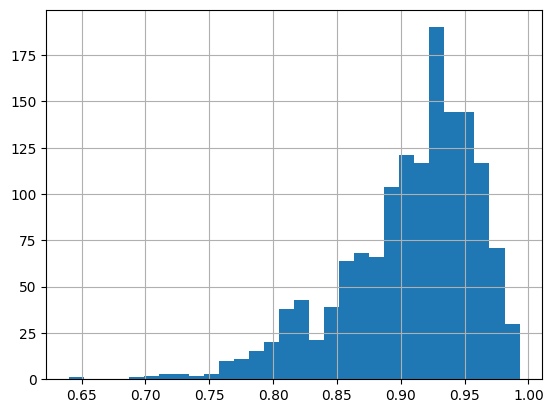

In [21]:
print(f"{eval_df.iou.mean()*100:.2f}%")
# plot IoU distribution
eval_df.iou.hist(bins=30)

In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
def index_to_implement_class(idx:int):
    return test_ds.implement_classes[idx]

cm_df = pd.DataFrame(confusion_matrix(eval_df.ground_truth, eval_df.class_pred))
cm_df.columns = [index_to_implement_class(i) for i in cm_df.columns]
cm_df.index = [index_to_implement_class(i) for i in cm_df.index]
cm_df

,Box Scraper;Land Pride;BB1272,Cannopy Sprayer;Rears;Pul Blast 300 Gallon Narrow,Disc;Domries;SN-2324,Flail Mower;Agrimaster;Yoyo 1500,Flail Mower;Nobili;VK 115,Flail Mower;Tierre;Lupo Revers 140,Flail Mower;Vrisimo;MM72,Rotary Mower;Bush Hog;BH215,Rotary Mower;Land Pride;RCR1260,Rotary Mower;Land Pride;RCR1872,Seeder;Great Plains;3P500V,Seeder;Schmeiser;VD48PW,Seeder;Schmeiser;VD60PW,Seeder;Schmeiser;VD72PW
Box Scraper;Land Pride;BB1272,106,0,0,0,0,0,0,0,0,0,0,0,0,0
Cannopy Sprayer;Rears;Pul Blast 300 Gallon Narrow,0,54,0,0,0,0,0,0,0,0,0,0,0,0
Disc;Domries;SN-2324,0,0,135,0,0,0,0,0,0,0,0,0,0,0
Flail Mower;Agrimaster;Yoyo 1500,0,0,0,135,0,0,0,0,0,0,0,0,0,0
Flail Mower;Nobili;VK 115,0,0,0,0,135,0,0,0,0,0,0,0,0,0
Flail Mower;Tierre;Lupo Revers 140,0,0,0,0,0,135,0,0,0,0,0,0,0,0
Flail Mower;Vrisimo;MM72,0,0,0,0,0,0,30,0,0,0,0,0,0,0
Rotary Mower;Bush Hog;BH215,0,0,0,0,0,0,0,135,0,0,0,0,0,0
Rotary Mower;Land Pride;RCR1260,0,0,0,0,0,0,0,0,86,0,0,0,0,0
Rotary Mower;Land Pride;RCR1872,0,0,0,0,0,0,0,0,0,28,0,0,0,0


In [18]:
classifications = eval_df.value_counts(['ground_truth','class_pred']).reset_index()
classifications['ground_truth'] = classifications.ground_truth.apply(lambda x: index_to_implement_class(x))
classifications['class_pred'] = classifications.class_pred.apply(lambda x: index_to_implement_class(x))
classifications.rename(columns={0:'count'}, inplace=True)
classifications['correct'] = classifications.ground_truth == classifications.class_pred
print(classifications.to_markdown(index=False))

| ground_truth                                      | class_pred                                        |   count | correct   |
|:--------------------------------------------------|:--------------------------------------------------|--------:|:----------|
| Disc;Domries;SN-2324                              | Disc;Domries;SN-2324                              |     135 | True      |
| Flail Mower;Agrimaster;Yoyo 1500                  | Flail Mower;Agrimaster;Yoyo 1500                  |     135 | True      |
| Flail Mower;Nobili;VK 115                         | Flail Mower;Nobili;VK 115                         |     135 | True      |
| Flail Mower;Tierre;Lupo Revers 140                | Flail Mower;Tierre;Lupo Revers 140                |     135 | True      |
| Rotary Mower;Bush Hog;BH215                       | Rotary Mower;Bush Hog;BH215                       |     135 | True      |
| Seeder;Schmeiser;VD72PW                           | Seeder;Schmeiser;VD72PW                           